In [2]:
#Charger le repertoire des scripts
import sys
import os
sys.path.append(os.path.abspath('./Library'))
import numpy as np
from matplotlib.pyplot import close, show
import matplotlib.pyplot as plt
import xarray as xr
from reef_models import reef_platform, reef, reef_eros
from tools import nlines
from tools_models import CheckSimu, ZarrName, shore
from Profile import Profile
from Dicts import Dicos
from datetime import datetime as dtime
from os import path
import xsimlab as xs
from Dict_models import DicoModels


## Model input dataset

In [68]:
class REEF:
    
    def __init__(self):
        # Define the fixed parameters
        self.input_vars = {
            # Water height for open ocean
            'hfactor__how': 2,
            # uniform spacing
            'grid__spacing': 1,
            # Grid width factor. Should be similar to hmax 
            'grid__dmax': 20,
            # Coefficient for erosion efficiency, sea-bed
            'eros__beta1': 0.1,
            # Coefficient for erosion efficiency, cliff retreat
            'eros__beta2': 1,
            # Height of notch for volume eroded during cliff retreat
            'eros__hnotch': 1,
            # Repos angle
            'depot__repos': 15e-2,
        }
    
    def reef_params(self, SL, U, slop, Gm, Ev, hmax=20, Dbar=100, hwb=3.):
        # Complete the dictionnary of fixed parameters with the ones to test
        self.input_vars.update({
            ## Usefull parameters to test. Everything in meters and years.
            # filename for RSL reconstruction
            'SLstory__RSLin': SL,
            # vertical land motion rate. [-10 - 2]e-3 (huge values, you can test before with 0.something e-3)
            'vertical__u': U,
            # initial slope of the substrate. [2 - 8]
            'grid__slopi': slop,
            # maximum reef growth rate. [2 - 15]
            'construct__Gm': Gm,            
            # Eroded volume. [50 - 1000]e-3
            'eros__Ev': Ev,
            # maximum water height for reef growth. [10 - 50] 
            'construct__hmax': hmax,
            # width of wave action (controls the width of the coral reef). [10 - 3000] 
            'hfactor__Dbar': Dbar,
            # Water height for wave base (the waves will start to erode at this depth). [1 - 10]
            'eros__hwb': float(hwb),
        })
        
    def run(self, dt, save):
        self.save = save
        dico = Dicos()
        # Define the output of the model
        if save==True:
            output = {
                'init__x'       : None,
                'profile__z'    : 'time',
                'sealevel__asl' : 'time',
                'profile__xmin' : None,
                'profile__xmax' : None,
                'depot__dS'     : 'time',
                'construct__dG' : 'time',
            }
        elif save==False:
            output={
                'init__x'       : None,
                'profile__z'    : None,
                'sealevel__asl' : None,
                'profile__xmin' : None,
                'profile__xmax' : None,
            }
        else:
            raise Exception("Wrong format for 'save' variable. Should be True or False")

        tmax = nlines(dico.path_SLcurves+self.input_vars['SLstory__RSLin'])*1e3
        # Create xsimlab setup
        ds_in = xs.create_setup(
            model=reef,
            clocks={'time' : np.arange(0., tmax+dt, dt)},
            master_clock = 'time',
            input_vars = self.input_vars,
            output_vars = output
        )
        ds_in.attrs['model_name'] = 'reef'
        ds_in.attrs['store'] = 'Profile'

        # Run the model
        t0=dtime.today()
        dm   = DicoModels()
        with dm.models[ds_in.model_name]:
            self.ds_out = (ds_in   
              .xsimlab.run()
                  )
        print('Duration', dtime.today()-t0)

    def plot(self):
        if self.save==True:
            print('Starting plot')
            fig = Profile(self.ds_out)
            fig.ProfileName('.png')
            fig.PlotProfile()
            fig.PlotASL()
            fig.WriteParams()
            fig.Savefig()
            show()
            close('all')
        elif self.save==False:
            plt.plot(self.ds_out.profile__z)
        else:
            raise Exception("Wrong format for 'layers' variable. Should be True or False")
        
REEF = REEF()

# Simple Holocene sea-level rise

## No vertical movement

In [52]:
# Set the variables
REEF.reef_params(SL = 'Holocene-SL.dat',
                U = 0e-3,
                slop = 6e-2,
                Gm = 9e-3,
                Ev = 60e-3)

# Run the model
REEF.run(dt = 200, save = True)

# Plot the output
REEF.plot()

## Subsidence

In [55]:
# Set the variables
REEF.reef_params(SL = 'Holocene-SL.dat',
                U = -0.6e-3,
                slop = 6e-2,
                Gm = 9e-3,
                Ev = 60e-3)

# Run the model
REEF.run(dt = 200, save = True)

# Plot the output
REEF.plot()

## Uplift

t 0.0
Duration 0:00:01.658611
Starting plot


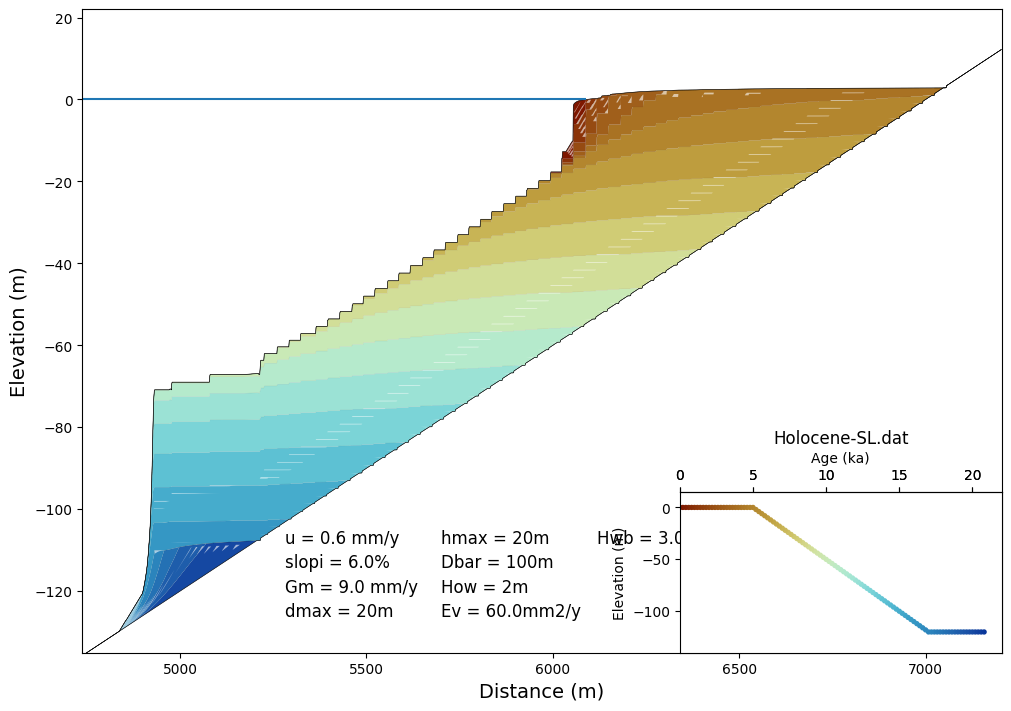

In [70]:
# Set the variables
REEF.reef_params(SL = 'Holocene-SL.dat',
                U = 0.6e-3,
                slop = 6e-2,
                Gm = 9e-3,
                Ev = 60e-3)

# Run the model
REEF.run(dt = 200, save = True)

# Plot the output
REEF.plot()

# Run

In [6]:
# Code to compute and plot at each time step
              
t0=dtime.today()
print(t0)

# Running the simulation if it doesn't exist
if CheckSimu(ds_in, simu=True, view=True):
    ds = xr.open_zarr(ZarrName(ds_in))

    # Plotting figure
    fig = Profile(ds)
    fig.ProfileName('.png')

#                             # If the figure already exists, skip the iteration
    if path.exists(fig.namepath+fig.namefig):
        print('Done')
        close('all')

    fig.PlotProfile()
#                             fig.PlotData('DemoProfil.txt')
    fig.PlotASL()
    fig.WriteParams()

    print('save')
    fig.Savefig()
    show()
    close('all')
    print('Duration', dtime.today()-t0)


2024-10-04 13:03:28.453929


NameError: name 'ds_in' is not defined

In [ ]:
### Run cell to compute only the last profile (with outputs on "None,None,None...")

from Dict_models import DicoModels

t0=dtime.today()

dm   = DicoModels()
with dm.models[ds_in.model_name]:
    ds_out = (ds_in   
      .xsimlab.run()
          )
print('Duration', dtime.today()-t0)


In [ ]:
### Plot the last profile, run the cell above firstly

plt.plot(ds_out.profile__z)

# # To zoom on the profile. First, let this commented, plot the profile and check where to zoom.
plt.xlim(4000,15000)
plt.ylim(-200,500)

In [ ]:
ds_out
